# Economic Data Revisions

_What we learn from history is that people don't learn from history_ - Warren Buffett 

Concepts:
- Retrieving data from the web
- Vintage economic data and revisions
- Payrolls employment indices
- St Louis Fed FRED, Archival FRED, and FRED-MD 
- Outliers

Referenes:
- https://fred.stlouisfed.org/
- https://research.stlouisfed.org/econ/mccracken/fred-databases/
- McCracken, M. W., & Ng, S. (2016). FRED-MD: A Monthly Database for Macroeconomic Research. Journal of Business & Economic Statistics, 34(4), 574–589.
- McCracken, M.W., Ng, S., 2020; FRED-QD: A Quarterly Database for
Macroeconomic Research, Federal Reserve Bank of St. Louis Working Paper 2020-
005
- Katrina Stierholz, 2018, Economic Data Revisions: What They Are and Where to Find Them
https://journals.ala.org/index.php/dttp/article/view/6383/8404


In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import textwrap
from finds.readers import Alfred, fred_md, fred_qd
from finds.utils import plot_date, plot_groupbar
from finds.recipes import is_outlier
from datetime import datetime
from secret import credentials
VERBOSE = 0
# %matplotlib qt

## Retrieving data from the web 

Data may be retrieved from the web by
1. Retrieving a structured file in csv, excel, json or any other format
2. Scraping a web page and searching for information near particular html tags or textual patterns
3. Calling API's provided to developers -- these are a set of protocols with which you can communicate with the web server 


### Retrieve a formatted file                                                             


In [2]:
# This URL is the location of the FRED-MD csv file, maintained by researchers at the St Louis FRED
url = 'https://files.stlouisfed.org/files/htdocs/fred-md/monthly/current.csv'

In [3]:
# Pandas has several built-in readers for csv, xml, json, excel and even html files          
df = pd.read_csv(url, header=0)
df

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
0,Transform:,5.000,5.0,5.000,5.000000e+00,5.00000,5.0000,5.0000,5.0000,5.0000,...,6.000,6.000,6.00,6.00,6.00,2.0,6.00,6.00,6.0000,1.0000
1,1/1/1959,2583.560,2426.0,15.188,2.766768e+05,18235.77392,21.9665,23.3891,22.2688,31.7011,...,18.294,10.152,2.13,2.45,2.04,NaN,6476.00,12298.00,84.2043,NaN
2,2/1/1959,2593.596,2434.8,15.346,2.787140e+05,18369.56308,22.3966,23.7048,22.4617,31.9337,...,18.302,10.167,2.14,2.46,2.05,NaN,6476.00,12298.00,83.5280,NaN
3,3/1/1959,2610.396,2452.7,15.491,2.777753e+05,18523.05762,22.7193,23.8483,22.5719,31.9337,...,18.289,10.185,2.15,2.45,2.07,NaN,6508.00,12349.00,81.6405,NaN
4,4/1/1959,2627.446,2470.0,15.435,2.833627e+05,18534.46600,23.2032,24.1927,22.9026,32.4374,...,18.300,10.221,2.16,2.47,2.08,NaN,6620.00,12484.00,81.8099,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779,11/1/2023,19225.440,15860.3,117.258,1.514120e+06,700707.00000,102.9382,101.2601,101.7148,102.3259,...,119.324,124.533,30.26,34.96,26.89,61.3,517477.03,918934.92,5008.1757,13.8563
780,12/1/2023,19265.016,15893.6,117.796,1.523993e+06,703256.00000,102.6149,100.8179,101.2544,101.7841,...,119.192,124.912,30.42,34.98,27.13,69.7,521938.91,921959.34,5085.0478,12.6960
781,1/1/2024,19382.171,15935.5,117.425,1.504096e+06,695631.00000,101.8110,100.3736,100.9190,101.6965,...,118.755,125.799,30.57,35.30,27.21,79.0,524940.39,924448.27,5112.8331,13.3453
782,2/1/2024,19370.105,15913.7,117.991,1.511532e+06,702712.00000,102.2599,100.5583,100.7451,100.8224,...,119.537,126.130,30.68,35.24,27.36,76.9,527544.90,925641.71,5111.0308,13.8808



### Scrape a web page                                                                      


In [4]:
# URL that displays the most popular series in the FRED economic data web site
url = f"https://fred.stlouisfed.org/tags/series?ob=pv&pageID=1"

In [5]:
# use requests package to retrieve the web page
import requests
data = requests.get(url)
data    # a response code of 200 indicates the request has succeeded

<Response [200]>

In [6]:
# the content is just a byte-string that you can parse with Python string or other methods
data.content[:200]

b'<!DOCTYPE html>\n<html lang="en">\n<head>\n    <meta http-equiv="X-UA-Compatible" content="IE=edge">\n    <meta charset="utf-8">\n                <title>Economic Data Series by Tag | FRED | St. Louis Fed</'

In [7]:
# use the BeautifulSoup package to parse html formats
from bs4 import BeautifulSoup
soup = BeautifulSoup(data.content, 'lxml')

# based on this snippet, we want to extract the href property of the series-title class tag
print(soup.decode()[39000:40000])

<h3><a class="series-title pager-series-title-gtm" href="/series/T10Y2Y" id="titleLink" style="font-size:1.2em; padding-bottom: 2px">10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity</a></h3>
</div>
<div class="display-results-popularity-bar d-none d-sm-block col-sm-2">
<span aria-label="popularity 100% popular" class="popularity-bar-span-parent" data-target="popularity-bar-span-T10Y2Y" tabindex="0" title="100% popular">
<span aria-hidden="true" class="popularity_bar" style="padding-top: 3px; padding-left:60px;"> </span> <span aria-hidden="true" class="popularity_bar_background" id="popularity-bar-span-T10Y2Y"> </span></span>
</div>
</td>
</tr>
<tr class="series-pager-attr">
<td colspan="2">
<div class="series-meta series-group-meta">
<span class="attributes">Percent, Not Seasonally Adjusted</span>
<br class="clear"/>
</div>
<div class="series-meta">
<input aria-labelledby="unitLinkT10Y2Y" class="pager-item-checkbox pager-check-series-gtm" name="sids[0]" type="

In [8]:
# identify all the tags whose class starts with 'series-title'
tags = soup.findAll(name='a', attrs={'class': 'series-title'})
tags[0]   # show first tag found

<a class="series-title pager-series-title-gtm" href="/series/T10Y2Y" id="titleLink" style="font-size:1.2em; padding-bottom: 2px">10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity</a>

In [9]:
# extract desired substring (which is a data series mnemonic) from the href property
details = [tag.get('href').split('/')[-1] for tag in tags]  # only want substring after last '/'
details[0]  # show first mnemonic string found

'T10Y2Y'

### Call an API

In [10]:
# an API call is simply a URL string containing your parameters for the request
url = "{root}?series_id={series_id}&file_type={file_type}&api_key={api_key}".format(
    root="https://api.stlouisfed.org/fred/series", # base url of the API call
    series_id=details[0],                          # mnemonic of the data series to retrieve
    file_type='json',                              # request data be returned in json format
    api_key=credentials['fred']['api_key'])        # private api key (obtain from FRED for free)

In [11]:
# make the API call to retrieve the data
data = requests.get(url)
data.content

b'{"realtime_start":"2024-05-03","realtime_end":"2024-05-03","seriess":[{"id":"T10Y2Y","realtime_start":"2024-05-03","realtime_end":"2024-05-03","title":"10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity","observation_start":"1976-06-01","observation_end":"2024-05-02","frequency":"Daily","frequency_short":"D","units":"Percent","units_short":"%","seasonal_adjustment":"Not Seasonally Adjusted","seasonal_adjustment_short":"NSA","last_updated":"2024-05-02 16:01:10-05","popularity":100,"notes":"Starting with the update on June 21, 2019, the Treasury bond data used in calculating interest rate spreads is obtained directly from the U.S. Treasury Department (https:\\/\\/www.treasury.gov\\/resource-center\\/data-chart-center\\/interest-rates\\/Pages\\/TextView.aspx?data=yield).\\r\\nSeries is calculated as the spread between 10-Year Treasury Constant Maturity (BC_10YEAR) and 2-Year Treasury Constant Maturity (BC_2YEAR). Both underlying series are published at the U.S. T

In [12]:
# use the json package to convert byte-string data content
import json
v = json.loads(data.content)
v

{'realtime_start': '2024-05-03',
 'realtime_end': '2024-05-03',
 'seriess': [{'id': 'T10Y2Y',
   'realtime_start': '2024-05-03',
   'realtime_end': '2024-05-03',
   'title': '10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity',
   'observation_start': '1976-06-01',
   'observation_end': '2024-05-02',
   'frequency': 'Daily',
   'frequency_short': 'D',
   'units': 'Percent',
   'units_short': '%',
   'seasonal_adjustment': 'Not Seasonally Adjusted',
   'seasonal_adjustment_short': 'NSA',
   'last_updated': '2024-05-02 16:01:10-05',
   'popularity': 100,
   'notes': 'Starting with the update on June 21, 2019, the Treasury bond data used in calculating interest rate spreads is obtained directly from the U.S. Treasury Department (https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield).\r\nSeries is calculated as the spread between 10-Year Treasury Constant Maturity (BC_10YEAR) and 2-Year Treasury Constant Maturity (B

In [13]:
# Pandas can create a DataFrame directly from a dict data structure
df = DataFrame(v['seriess'])
df

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
0,T10Y2Y,2024-05-03,2024-05-03,10-Year Treasury Constant Maturity Minus 2-Yea...,1976-06-01,2024-05-02,Daily,D,Percent,%,Not Seasonally Adjusted,NSA,2024-05-02 16:01:10-05,100,"Starting with the update on June 21, 2019, the..."


## FRED

Short for Federal Reserve Economic Data, FRED is an online database consisting of hundreds of thousands of economic data time series from national, international, public, and private sources. Created and maintained by the Research Department at the Federal Reserve Bank of St. Louis, FRED data can be downloaded from their website, an Excel add-in, or through api calls.

Archival FRED, or ALFRED, is a superset of FRED that allows you to retrieve vintage versions of economic data that were available on specific dates in history. 

In [14]:
today = int(datetime.today().strftime('%Y%m%d'))
alf = Alfred(api_key=credentials['fred']['api_key'], verbose=VERBOSE)

### Popular FRED series

In addition to being tagged by categories, frequencies, seasonal adjustments, sources and numerous concepts which can be filtered on, FRED series titles can also be sorted by update recency and popularity. The most popular series currently are:   

- https://fred.stlouisfed.org/tags/series?ob=pv&pageID=1


In [15]:
# scrape FRED most popular page
popular = {}
titles = Alfred.popular(1)  
for title in titles:
    series = alf.request_series(title)   # requests 'series' FRED api
    if not series.empty:
        popular[title] = series.iloc[-1][['title', 'popularity']]
print(f"Most Popular Series in FRED, retrieved {today}")
DataFrame.from_dict(popular, orient='index')

Most Popular Series in FRED, retrieved 20240503


,title,popularity
T10Y2Y,10-Year Treasury Constant Maturity Minus 2-Yea...,100
MORTGAGE30US,30-Year Fixed Rate Mortgage Average in the Uni...,99
FEDFUNDS,Federal Funds Effective Rate,98
M2SL,M2,93
RRPONTSYD,Overnight Reverse Repurchase Agreements: Treas...,95
CPIAUCSL,Consumer Price Index for All Urban Consumers: ...,95
UNRATE,Unemployment Rate,95
WALCL,Assets: Total Assets: Total Assets (Less Elimi...,94
T10Y3M,10-Year Treasury Constant Maturity Minus 3-Mon...,94
GDP,Gross Domestic Product,93


Text(0.5, 0.98, 'FRED Most Popular series (retrieved 20240503)')

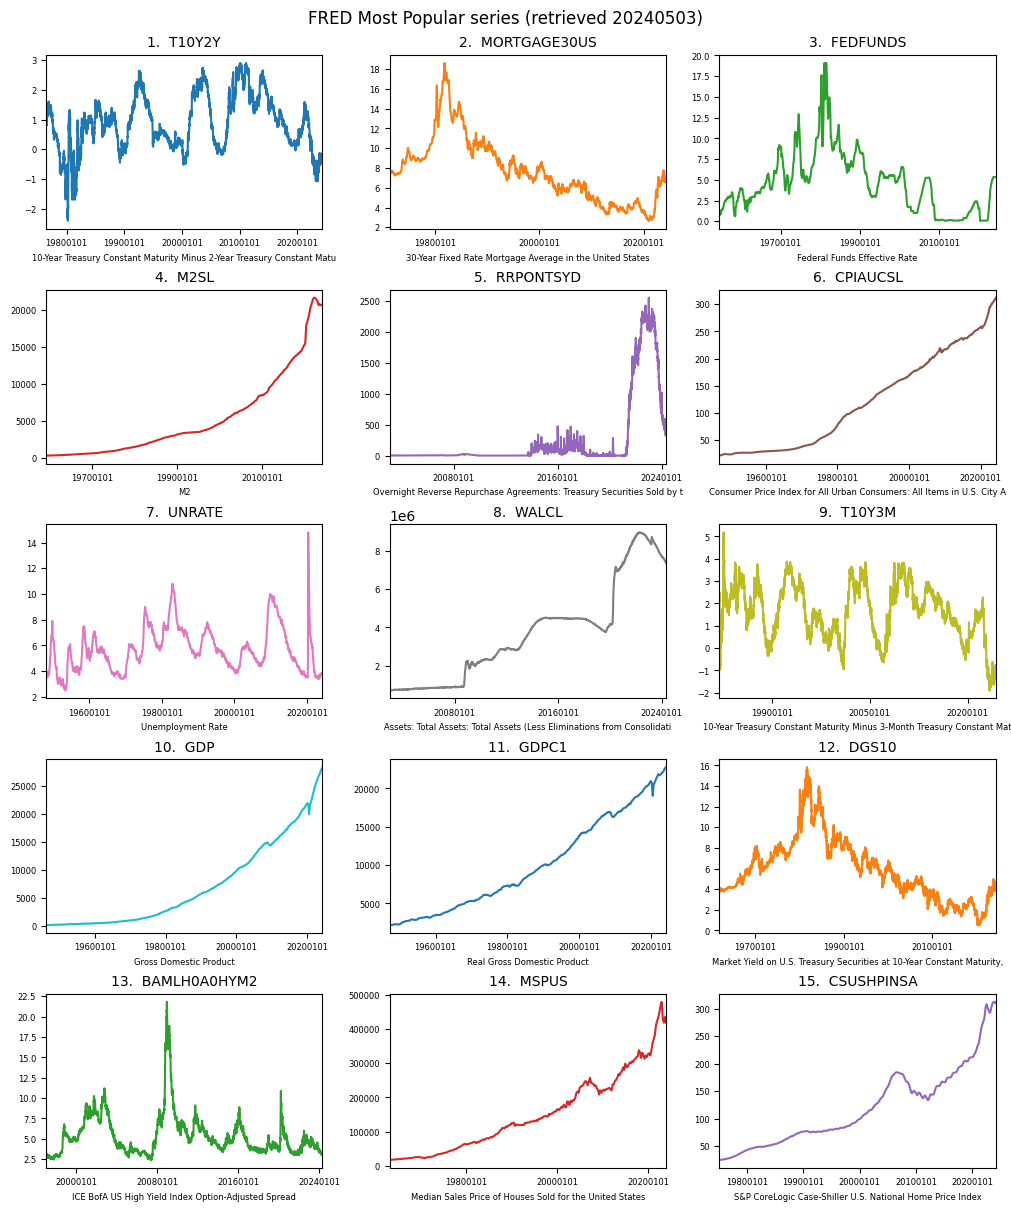

In [40]:
# plot popular series
fig, axes = plt.subplots(ncols=3, nrows=5, figsize=(10, 12), layout='constrained')
for cn, (ax, title) in enumerate(zip(np.ravel(axes), titles[:15])):
    series = alf(title)
    plot_date(series, ax=ax, title=f"{cn+1}.  {title}", xlabel=alf.header(title)[:70],
              fontsize=6, ls='-', cn=cn, nbins=4)
plt.suptitle(f"FRED Most Popular series (retrieved {today})")

### FRED series categories

Retrieve Total Non-Farm Payroll (PAYEMS) and its parent categories

In [17]:
# Retrieve grandparent,  parent and siblings of series                               
series_id, freq = 'PAYEMS', 'M'
category = alf.categories(series_id).iloc[0]
grand_category = alf.get_category(category['parent_id'])
parent_category = alf.get_category(category['id'])
category.to_frame().T


,id,name,parent_id
PAYEMS,32305,Total Nonfarm,11


In [18]:
print(f"Super category {grand_category['id']}: {grand_category['name']}")
if 'notes' in grand_category:
    print(textwrap.fill(grand_category['notes']))

Super category 11: Current Employment Statistics (Establishment Survey)
The establishment survey provides data on employment, hours, and
earnings by industry.  Numerous conceptual and methodological
differences between the current population (household) and
establishment surveys result in important distinctions in the
employment estimates derived from the surveys. Among these are:   The
household survey includes agricultural workers, the self- employed,
unpaid family workers, and private household workers among the
employed. These groups are excluded from the establishment survey.
The household survey includes people on unpaid leave among the
employed. The establishment survey does not.   The household survey is
limited to workers 16 years of age and older. The establishment survey
is not limited by age.   The household survey has no duplication of
individuals, because individuals are counted only once, even if they
hold more than one job. In the establishment survey, employees working

In [19]:
print("Parent categories:")
for child in grand_category['children']:
    node = alf.get_category(child['id'])
    if node:
        print(f" {node['id']}: {node['name']} "
              f" (children={len(node['children'])}, series={len(node['series'])})")

Parent categories:
 32305: Total Nonfarm  (children=0, series=5)
 32306: Total Private  (children=0, series=27)
 32307: Goods-Producing  (children=0, series=27)
 32326: Service-Providing  (children=0, series=1)
 32308: Private Service-Providing  (children=0, series=27)
 32309: Mining and Logging  (children=0, series=39)
 32310: Construction  (children=0, series=41)
 32311: Manufacturing  (children=0, series=31)
 32312: Durable Goods  (children=0, series=63)
 32313: Nondurable Goods  (children=0, series=55)
 32314: Trade, Transportation, and Utilities  (children=0, series=27)
 32315: Wholesale Trade  (children=0, series=33)
 32316: Retail Trade  (children=0, series=55)
 32317: Transportation and Warehousing  (children=0, series=47)
 32318: Utilities  (children=0, series=27)
 32319: Information  (children=0, series=39)
 32320: Financial Activities  (children=0, series=51)
 32321: Professional and Business Services  (children=0, series=55)
 32322: Education and Health Services  (children=

In [20]:
print("Sibling series:")
for child in parent_category['series']:
    if child['id'] == series_id:
        node = child
    print(f"  {child['id']}: {child['title']} {child['seasonal_adjustment']}"
          f" (popularity={child['popularity']})")

Sibling series:
  CES0000000010: Women Employees, Total Nonfarm Seasonally Adjusted (popularity=4)
  CES0000000039: Women Employees-To-All Employees Ratio: Total Nonfarm Seasonally Adjusted (popularity=16)
  CEU0000000010: Women Employees, Total Nonfarm Not Seasonally Adjusted (popularity=1)
  PAYEMS: All Employees, Total Nonfarm Seasonally Adjusted (popularity=83)
  PAYNSA: All Employees, Total Nonfarm Not Seasonally Adjusted (popularity=47)


In [21]:
print(f"{node['id']}: {node['title']} {node['seasonal_adjustment']}",
      f" ({node['observation_start']}-{node['observation_end']})")
print()
print(textwrap.fill(node['notes']))

PAYEMS: All Employees, Total Nonfarm Seasonally Adjusted  (1939-01-01-2024-03-01)

All Employees: Total Nonfarm, commonly known as Total Nonfarm Payroll,
is a measure of the number of U.S. workers in the economy that
excludes proprietors, private household employees, unpaid volunteers,
farm employees, and the unincorporated self-employed. This measure
accounts for approximately 80 percent of the workers who contribute to
Gross Domestic Product (GDP).  This measure provides useful insights
into the current economic situation because it can represent the
number of jobs added or lost in an economy. Increases in employment
might indicate that businesses are hiring which might also suggest
that businesses are growing. Additionally, those who are newly
employed have increased their personal incomes, which means (all else
constant) their disposable incomes have also increased, thus fostering
further economic expansion.  Generally, the U.S. labor force and
levels of employment and unemployment

### Revisions and vintage dates

Economic data for past observation periods are revised as more accurate estimates become available. As a result, previous vintages of data can be superseded. ALFRED, the archival FRED tool, captures these data revisions.

On the first Friday of every month, the Bureau of Labor Statistics (BLS) publishes its Employment Situation Summary, which contains the highly-anticipated Total Nonfarm Payroll Employment based on firms’ reports of the number of people employed. However, it is a very rough estimate and is revised the following month, and then again the month after as more information arrives at the BLS. These revisions can be large and may materially change the picture of the economy. 



In [22]:
start, end = 20230101, 20231231
data = {}
print(f"{alf.header(series_id)} (retrieved {today}):")
latest = alf(series_id, start=start, end=end, freq=freq, realtime=True)
latest

All Employees, Total Nonfarm (retrieved 20240503):


,PAYEMS,realtime_start,realtime_end
date,,,
20230131,154773,20240202,99991231
20230228,155060,20240202,99991231
20230331,155206,20240202,99991231
20230430,155484,20240202,99991231
20230531,155787,20240202,99991231
20230630,156027,20240202,99991231
20230731,156211,20240202,99991231
20230831,156421,20240202,99991231
20230930,156667,20240202,99991231


In [23]:
print("First Release:")
data[0] = alf(series_id, release=1, start=start, end=end, freq=freq, realtime=True)
data[0]

First Release:


,PAYEMS,realtime_start,realtime_end
date,,,
20230131,155073,20230203,20230309
20230228,155350,20230310,20230406
20230331,155569,20230407,20230504
20230430,155673,20230505,20230601
20230531,156105,20230602,20230706
20230630,156204,20230707,20230803
20230731,156342,20230804,20230831
20230831,156419,20230901,20231005
20230930,156874,20231006,20231102


In [24]:
print("Second Release:")
data[1] = alf(series_id, release=2, start=start, end=end, freq=freq, realtime=True)
data[1]

Second Release:


,PAYEMS,realtime_start,realtime_end
date,,,
20230131,155039,20230310,20230406
20230228,155333,20230407,20230504
20230331,155420,20230505,20230601
20230430,155766,20230602,20230706
20230531,155995,20230707,20230803
20230630,156155,20230804,20230831
20230731,156232,20230901,20231005
20230831,156538,20231006,20231102
20230930,156773,20231103,20231207


In [25]:
print("Third Release:")
data[2] = alf(series_id, release=3, start=start, end=end, freq=freq, realtime=True)
data[2]

Third Release:


,PAYEMS,realtime_start,realtime_end
date,,,
20230131,155007,20230407,20240201
20230228,155255,20230505,20240201
20230331,155472,20230602,20240201
20230430,155689,20230707,20240201
20230531,155970,20230804,20240201
20230630,156075,20230901,20240201
20230731,156311,20231006,20240201
20230831,156476,20231103,20240201
20230930,156738,20231208,20240201


In [26]:
print("Fourth Release:")
data[3] = alf(series_id, release=4, start=start, end=end, freq=freq, realtime=True)
data[3]

Fourth Release:


,PAYEMS,realtime_start,realtime_end
date,,,
20230131,154773,20240202,99991231
20230228,155060,20240202,99991231
20230331,155206,20240202,99991231
20230430,155484,20240202,99991231
20230531,155787,20240202,99991231
20230630,156027,20240202,99991231
20230731,156211,20240202,99991231
20230831,156421,20240202,99991231
20230930,156667,20240202,99991231


In [27]:
df = pd.concat([(data[i][series_id] - data[i-1][series_id]).rename(f"Revision {i}")
                for i in range(1, len(data))], axis=1)
labels = pd.concat([data[i]['realtime_start'].rename(f"Revision {i}")
                    for i in range(1, len(data))], axis=1).fillna(0).astype(int)
DataFrame(df.sum(axis=0).rename("Total revisions ('000)"))

,Total revisions ('000)
Revision 1,-349.0
Revision 2,-348.0
Revision 3,-1368.0


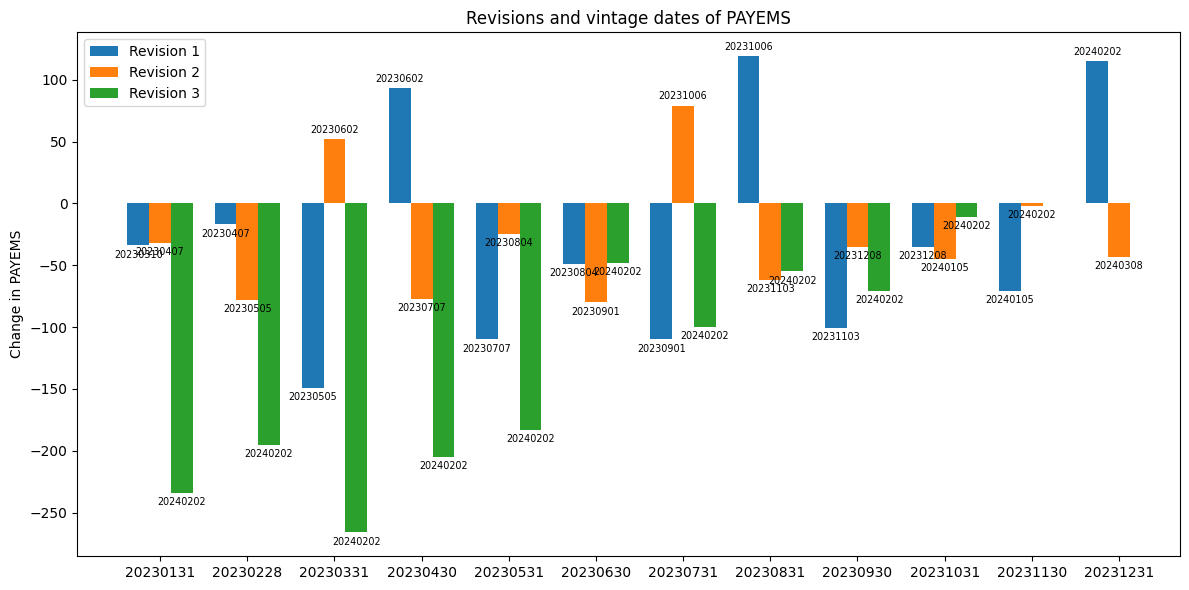

In [28]:
#df = pd.concat([data[i][series_id].rename(f"Revision {i}")
#                for i in range(1, len(data))], axis=1)
#labels = pd.concat([data[i]['realtime_start'].rename(f"Revision {i}")
#                    for i in range(1, len(data))], axis=1).fillna(0).astype(int)
fig, ax = plt.subplots(figsize=(12, 6))
plot_groupbar(df, labels=labels, ax=ax)
plt.legend()
plt.ylabel(f'Change in {series_id}')
plt.title(f'Revisions and vintage dates of {series_id}')
plt.tight_layout()
plt.show()

TODO: Explain, and initial and final ADP and JOLTS cumulative graphs over past year

## FRED-MD and FRED-QD

FRED-MD and FRED-QD are datasets of monthly and quarterly observations mimic the coverage of macroeconomic datasets already used in the literature. They are updated in real-time through the FRED database, and relieve the researcher of the task of incorporating data changes and revisions (a task accomplished by the data desk at the Federal Reserve Bank of St. Louis). 


### Release dates

In [29]:
md_df, md_transform = fred_md()
end = md_df.index[-1]
out = {}
for i, title in enumerate(md_df.columns):
    out[title] = alf(series_id=title,
                     release=1,
                     start=end, # within 4 days of monthend
                     end=end,
                     realtime=True)
    if title.startswith('S&P'):  # stock market data available same day close
        out[title] = Series({end: end}, name='realtime_start').to_frame()
    elif title in alf.splice_:   # these series were renamed or spliced
        if isinstance(Alfred.splice_[title], str):  # if renamed
            out[title] = alf(series_id=Alfred.splice_[title],
                             release=1,
                             start=end-4,  # within 4 days of monthend
                             end=end,
                             realtime=True)
        else:  # if FRED-MD series was spliced
            out[title] = pd.concat([alf(series_id=sub,
                                        reglease=1,
                                        start=end-4,  # within 4 days of monthend
                                        end=end,
                                        realtime=True)
                                    for sub in Alfred.splice_[title][1:]])

FRED-MD vintage: monthly/current.csv


In [30]:
# date convention of Consumer Sentiment
df = alf('UMCSENT', release=1, realtime=True)
out['UMCSENT'] = df[df['realtime_start'] > end - 4].iloc[:1]

In [31]:
# weekly averages of Claims
df = alf('ICNSA', release=1, realtime=True)
out['CLAIMS'] = df[df['realtime_start'] > end - 4].iloc[:1]

In [32]:
# Plot release dates of series in FRED-MD
release = Series({k: str(min(v['realtime_start'])) if v is not None and len(v)
                  else None  for k,v in out.items()}).sort_values()

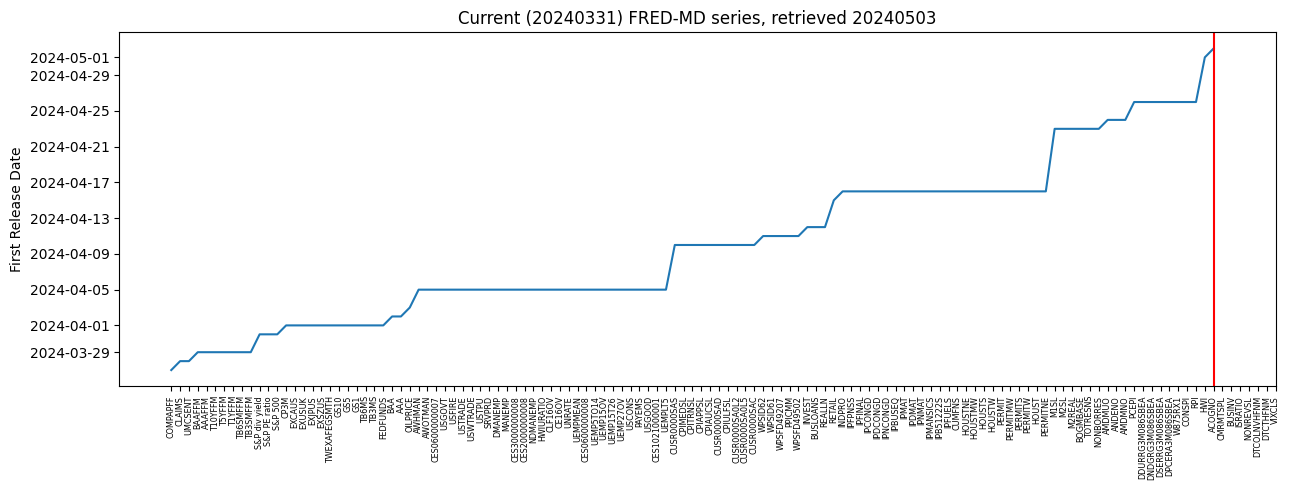

In [33]:
fig, ax = plt.subplots(clear=True, num=1, figsize=(13, 5))
ax.plot(pd.to_datetime(release, errors='coerce'))
ax.axvline(release[~release.isnull()].index[-1], c='r')
ax.set_title(f"Current ({end}) FRED-MD series, retrieved {today}")
ax.set_ylabel('First Release Date')
ax.set_xticks(np.arange(len(release)))
ax.set_xticklabels(release.index, rotation=90, fontsize='xx-small')
plt.tight_layout()

In [34]:
# Check if recently released data available to update latest FRED-MD                         
md_missing = md_df.iloc[-1]
md_missing = md_missing[md_missing.isnull()]
print("Recent values available to update missing in current FRED-MD")
for series_id in md_missing.index:
    print(alf.splice(series_id).iloc[-3:])


Recent values available to update missing in current FRED-MD
date
20231231    1523993.0
20240131    1504096.0
20240229    1511532.0
Name: CMRMTSPL, dtype: float64
date
20240131    243376.0
20240229    249075.0
20240331    251771.0
Name: ACOGNO, dtype: float64
date
20231231    2555879.0
20240131    2556109.0
20240229    2567540.0
Name: BUSINV, dtype: float64
date
20231231    1.38
20240131    1.39
20240229    1.38
Name: ISRATIO, dtype: float64
date
20231231    3700.45907
20240131    3709.54790
20240229    3712.40931
Name: NONREVSL, dtype: float64
date
20240131    0.156926
20240229    0.156615
20240331         NaN
Name: CONSPI, dtype: float64
date
20240331    34.37
20240430    34.66
20240531    33.62
Name: S&P PE ratio, dtype: float64
date
20231231    521938.91
20240131    524940.39
20240229    527544.90
Name: DTCOLNVHFNM, dtype: float64
date
20231231    921959.34
20240131    924448.27
20240229    925641.71
Name: DTCTHFNM, dtype: float64


In [35]:
# Find any missing series observations, if any, now available to update current FRED-MD
Series(release.values, index=[(s, alf.header(s)) for s in release.index])\
    .tail(len(md_missing))

(HWI, Help Wanted Index for United States)                                                       20240501
(ACOGNO, Manufacturers' New Orders: Consumer Goods)                                              20240502
(CMRMTSPL, Real Manufacturing and Trade Industries Sales)                                            None
(BUSINV, Total Business Inventories)                                                                 None
(ISRATIO, Total Business: Inventories to Sales Ratio)                                                None
(NONREVSL, Nonrevolving Consumer Credit Owned and Securitized)                                       None
(DTCOLNVHFNM, Consumer Motor Vehicle Loans Owned by Finance Companies, Level)                        None
(DTCTHFNM, Total Consumer Loans and Leases Owned and Securitized by Finance Companies, Level)        None
(VIXCLS, CBOE Volatility Index: VIX)                                                                 None
dtype: object

## Outliers

- John Tukey proposed this criterian, where k = 1.5 indicates an "outlier", and k = 3 indicates data that is "far out".

- iq10:  require within median +/- [10 times interquartile range Q3-Q1]
- tukey:  [Q1 - 1.5(Q3-Q1), Q3 + 1.5(Q3-Q1)] 
- farout : tukey with 3IQ instead of 1.5IQ

TODO:
- separate graphs by method (too busy) -- number of outliers not fraction
- list of months with most combined outliers, show number of each

In [ ]:
outliers = dict()
for method in ['iq10', 'tukey', 'farout']:
    outliers[method] = np.sum(is_outlier(data, method=method), axis=1)
fig, ax = plt.subplots(figsize=(10,6))
plt.step(data.index[12:], DataFrame(outliers)[12:] / data.shape[1], where='mid')
plt.title('Fraction of outlier observations by month')
plt.legend(outliers.keys())
plt.tight_layout()

In [ ]:
print('Frequency of outliers by method')
for method, num in outliers.items():
    print(f"{method:6s}: {np.mean(num):5.1f}/{data.shape[1]} outliers per month")